<a href="https://colab.research.google.com/github/ayyucedemirbas/RNA-seq_data_normalization/blob/main/scRNA_seq_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
if (!requireNamespace("glmGamPoi", quietly = TRUE))
    BiocManager::install("glmGamPoi")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Installing package(s) 'BiocVersion', 'glmGamPoi'

also installing the dependencies ‘abind’, ‘rhdf5filters’, ‘Rhdf5lib’, ‘sparseMatrixStats’, ‘IRanges’, ‘S4Arrays’, ‘XVector’, ‘h5mread’, ‘rhdf5’, ‘GenomicRanges’, ‘Biobase’, ‘Seqinfo’, ‘beachmat’, ‘DelayedMatrixStats’, ‘matrixStats’, ‘MatrixGenerics’, ‘SparseArray’, ‘S4Vectors’, ‘DelayedArray’, ‘HDF5Array’, ‘SummarizedExperiment’, ‘SingleCellExperiment’, ‘BiocGenerics’, ‘RcppArmadillo’, ‘assorthead’


Old packages: 'base64enc', 'broom', 'bslib', 'cluster', 'cpp11', 'data.table',
  'dplyr', 'foreign', 'gargle', 'ggplot2', 'lubridate', 'pkgload', 'rappdirs',
  'timechange', 'uuid', 'vctrs', 'viridisLite', 'vroom', 'xfun', 'xml2'



In [3]:
if (!requireNamespace("Seurat", quietly = TRUE))
    install.packages("Seurat")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘dotCall64’, ‘gtools’, ‘caTools’, ‘plyr’, ‘tensor’, ‘BH’, ‘sitmo’, ‘sp’, ‘spam’, ‘globals’, ‘listenv’, ‘parallelly’, ‘zoo’, ‘lazyeval’, ‘crosstalk’, ‘RcppTOML’, ‘here’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘spatstat.data’, ‘spatstat.univar’, ‘spatstat.random’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘goftest’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘dqrng’, ‘SeuratObject’, ‘cowplot’, ‘fastDummies’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘lmtest’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘progressr’, ‘RANN’, ‘RcppAnnoy’, ‘RcppHNSW’, ‘reticulate’, ‘ROCR’, ‘RSpectra’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘spatstat.explore’, ‘spatstat.geom’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’




In [4]:
if (!requireNamespace("sctransform", quietly = TRUE))
    install.packages("sctransform")

In [5]:
if (!requireNamespace("Matrix", quietly = TRUE))
    install.packages("Matrix")

In [6]:
if (!requireNamespace("ggplot2", quietly = TRUE))
    install.packages("ggplot2")

In [7]:
library(Seurat)
library(sctransform)
library(glmGamPoi)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘ggplot2’


The following object is masked from ‘package:glmGamPoi’:

    vars




In [8]:
data_dir <- "pbmc3k_data"
if (!dir.exists(data_dir)) dir.create(data_dir)

In [9]:
url <- "https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz"
dest_file <- file.path(data_dir, "pbmc3k_filtered_gene_bc_matrices.tar.gz")

In [10]:
if (!file.exists(dest_file)) {
  message("Downloading PBMC 3k dataset (~7MB)...")
  download.file(url, destfile = dest_file)
}

In [11]:
untar(dest_file, exdir = data_dir)

matrix_dir <- file.path(data_dir, "filtered_gene_bc_matrices/hg19")

In [12]:
pbmc_data <- Read10X(data.dir = matrix_dir)

In [13]:
seurat_object <- CreateSeuratObject(counts = pbmc_data, project = "pbmc3k", min.cells = 3, min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [14]:
message(paste("Loaded:", nrow(seurat_object), "genes x", ncol(seurat_object), "cells"))

Loaded: 13714 genes x 2700 cells



In [15]:
seurat_object[["percent.mt"]] <- PercentageFeatureSet(seurat_object, pattern = "^MT-")

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


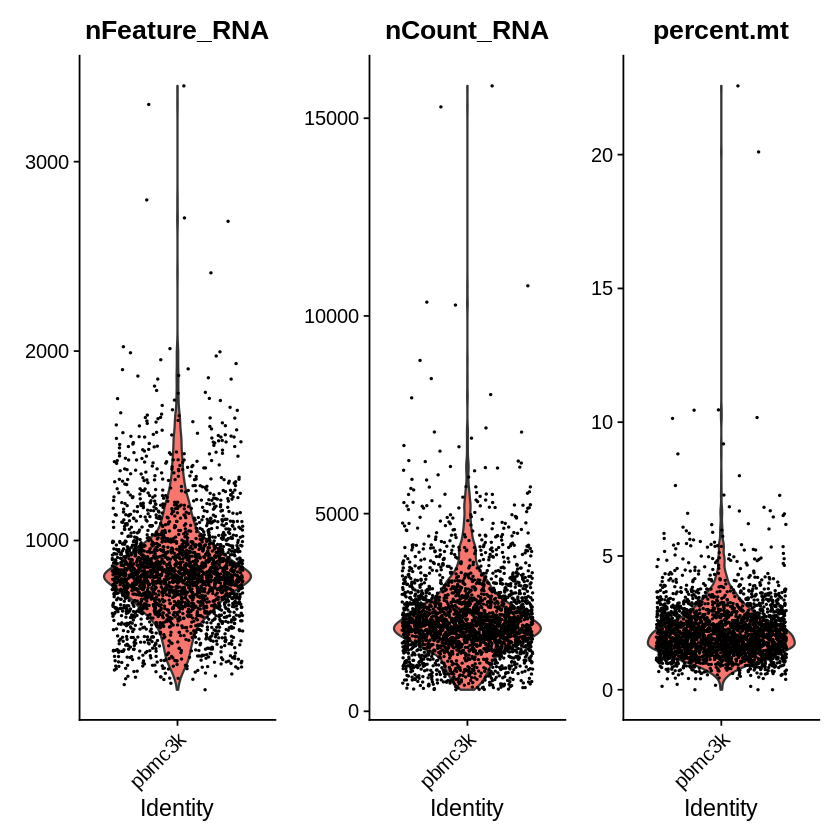

In [16]:
VlnPlot(seurat_object, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_hline()`).”


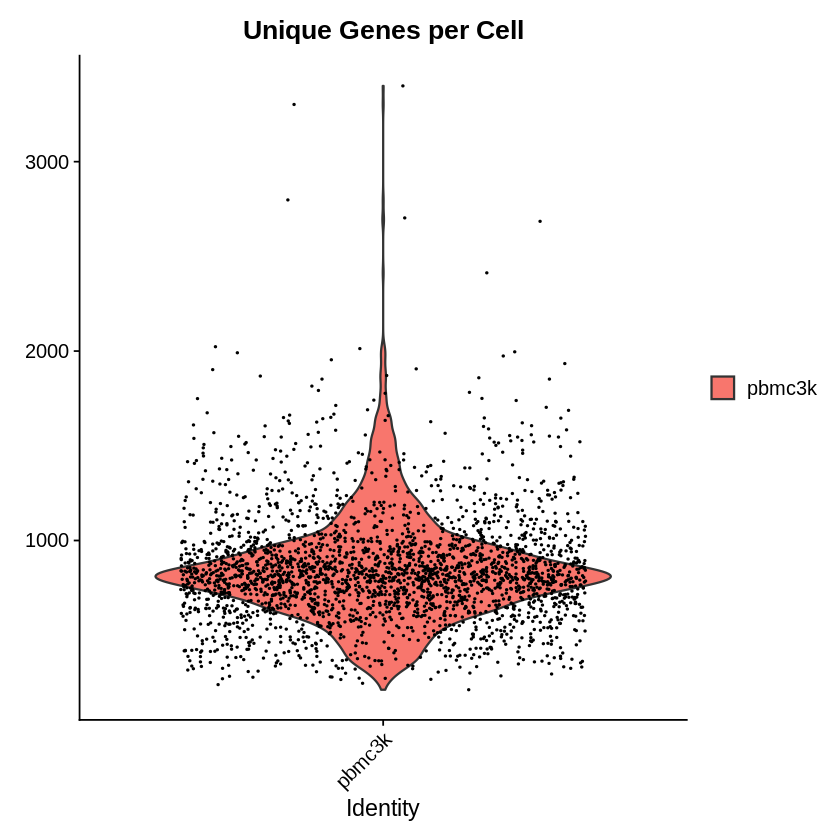

In [17]:
VlnPlot(seurat_object, features = "nFeature_RNA") +
  geom_hline(yintercept = 200, color = "red", linetype = "dashed") +
  ggtitle("Unique Genes per Cell")

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


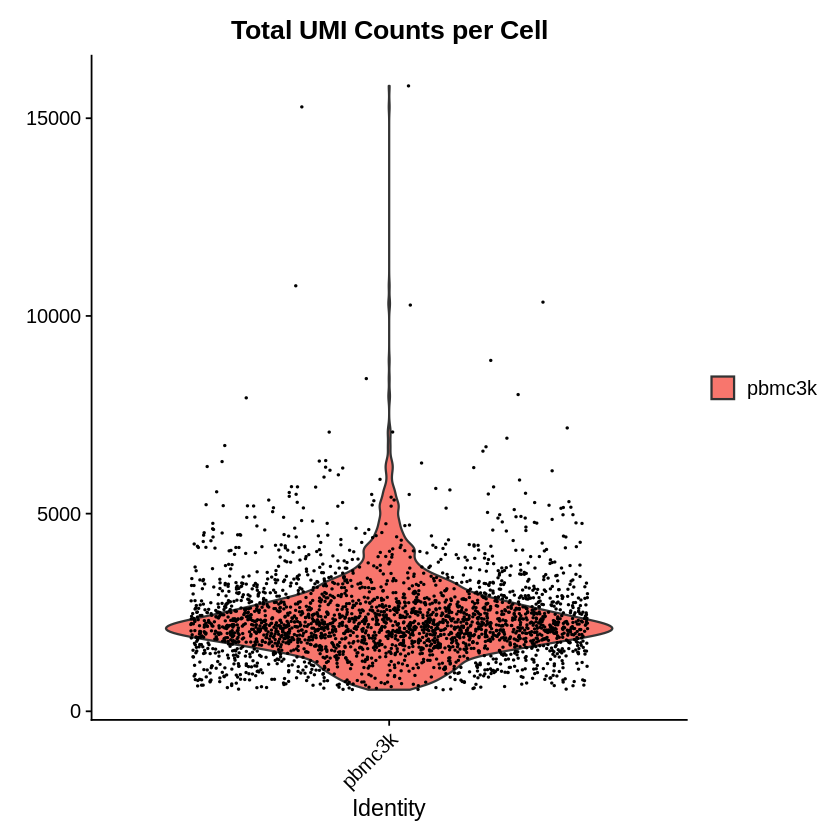

In [18]:
VlnPlot(seurat_object, features = "nCount_RNA") +
  ggtitle("Total UMI Counts per Cell")

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


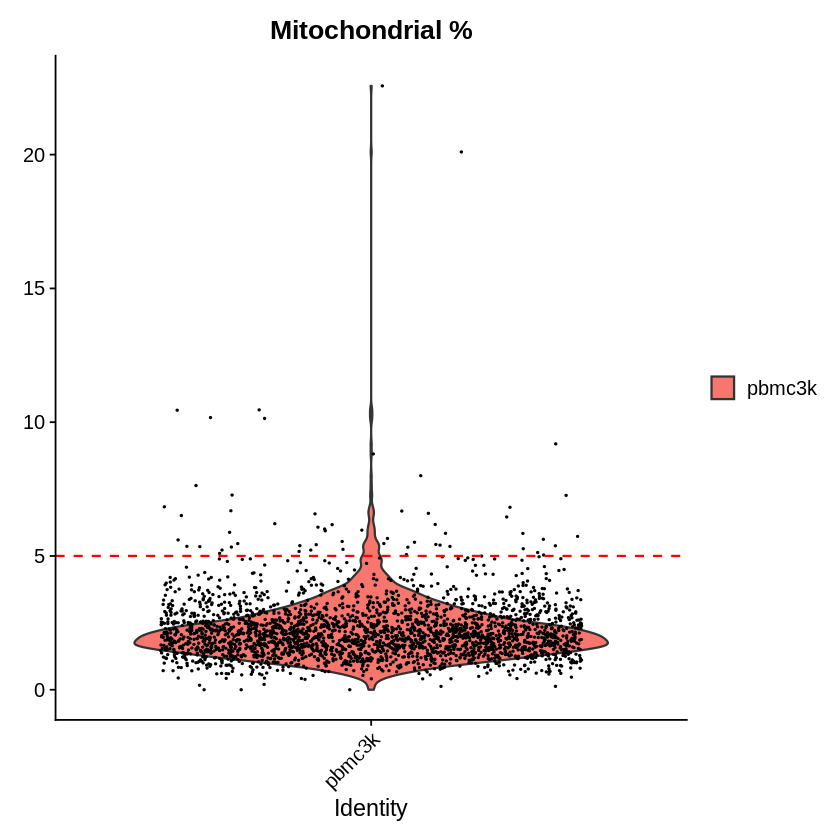

In [19]:
VlnPlot(seurat_object, features = "percent.mt") +
  geom_hline(yintercept = 5, color = "red", linetype = "dashed") +
  ggtitle("Mitochondrial %")

In [20]:
seurat_object <- subset(seurat_object, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

In [21]:
seurat_object <- SCTransform(
  seurat_object,
  method = "glmGamPoi",
  vars.to.regress = "percent.mt",
  verbose = TRUE,
  vst.flavor = "v2"
)

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 12519 by 2638

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2638 cells

Found 56 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 12519 genes

Computing corrected count matrix for 12519 genes

Calculating gene attributes

Wall clock passed: Time difference of 26.32076 secs

Determine variable features

Regressing out percent.mt

Centering data matrix

Place corrected count matrix in counts slot

Set default assay to SCT



In [23]:
sct_features <- as.data.frame(seurat_object[["SCT"]]@meta.features)

In [24]:
print(colnames(sct_features))

character(0)


vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 12519 by 2638

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2000 cells

Found 216 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 12519 genes

Calculating gene attributes

Wall clock passed: Time difference of 12.48588 secs



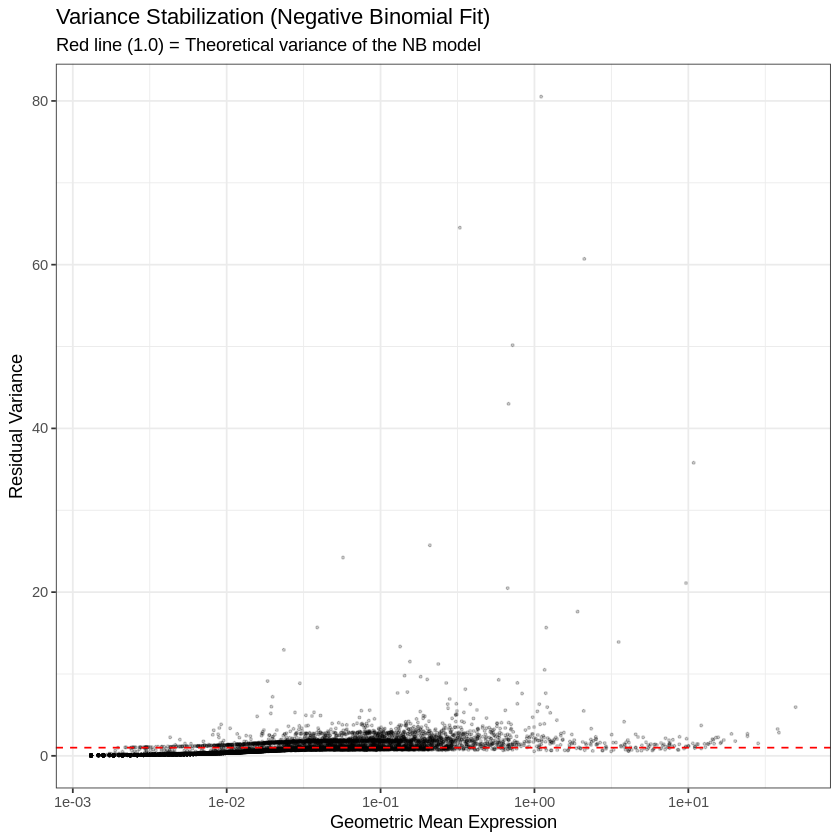

In [30]:
raw_counts <- GetAssayData(seurat_object, assay = "RNA", layer = "counts")

vst_out <- sctransform::vst(
  raw_counts,
  method = "glmGamPoi",
  vst.flavor = "v2",
  verbosity = 1
)

plot_data <- vst_out$gene_attr

x_col <- ifelse("gmean" %in% colnames(plot_data), "gmean", "geometric_mean")

ggplot(plot_data, aes(x = .data[[x_col]], y = residual_variance)) +
  geom_point(alpha = 0.2, size = 0.5) +
  scale_x_log10() +
  geom_hline(yintercept = 1, color = "red", linetype = "dashed") +
  labs(
    title = "Variance Stabilization (Negative Binomial Fit)",
    subtitle = "Red line (1.0) = Theoretical variance of the NB model",
    x = "Geometric Mean Expression",
    y = "Residual Variance"
  ) +
  theme_bw()

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


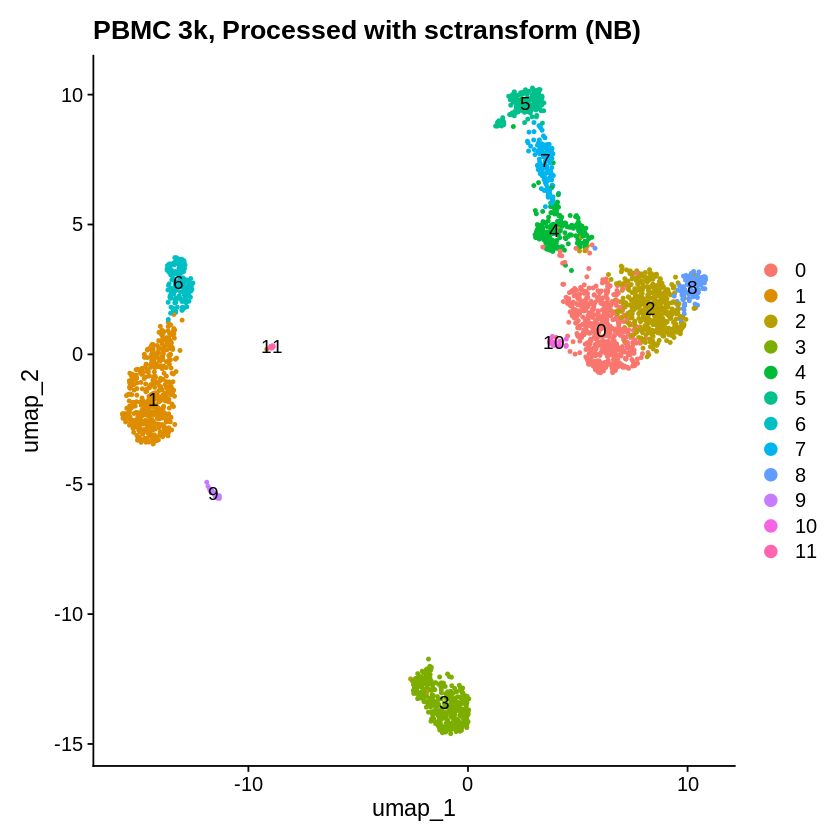

In [32]:
seurat_object <- RunPCA(seurat_object, verbose = FALSE)
seurat_object <- RunUMAP(seurat_object, dims = 1:30, verbose = FALSE)
seurat_object <- FindNeighbors(seurat_object, dims = 1:30, verbose = FALSE)
seurat_object <- FindClusters(seurat_object, verbose = FALSE)

DimPlot(seurat_object, label = TRUE) + ggtitle("PBMC 3k, Processed with sctransform (NB)")

In [33]:
DefaultAssay(seurat_object) <- "RNA"
seurat_object <- NormalizeData(seurat_object, verbose = FALSE)
seurat_object <- ScaleData(seurat_object, verbose = FALSE)

all_markers <- FindAllMarkers(seurat_object, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



In [34]:
library(dplyr)
top_markers <- all_markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

print(top_markers)


Attaching package: ‘dplyr’


The following object is masked from ‘package:glmGamPoi’:

    vars


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# A tibble: 24 × 7
# Groups:   cluster [12]
       p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene     
       <dbl>      <dbl> <dbl> <dbl>     <dbl> <fct>   <chr>    
 1 1.57e- 69       2.40 0.426 0.105 2.16e- 65 0       AQP3     
 2 1.36e- 53       2.33 0.293 0.059 1.87e- 49 0       CD40LG   
 3 8.40e-135       7.05 0.294 0.005 1.15e-130 1       FOLR3    
 4 0               6.73 0.969 0.12  0         1       S100A8   
 5 1.34e- 87       2.32 0.513 0.126 1.84e- 83 2       CCR7     
 6 2.56e- 41       1.88 0.366 0.121 3.51e- 37 2       LEF1     
 7 3.18e-267       7.21 0.558 0.01  4.36e-263 3       LINC00926
 8 1.10e-235       7.13 0.486 0.007 1.51e-231 3       VPREB3   
 9 9.03e-176       4.14 0.707 0.065 1.24e-171 4       GZMK     
10 1.21e- 32       2.91 0.323 0.075 1.65e- 28 4       NCR3     
# ℹ 14 more rows


In [35]:
# MS4A1 = B Cells
# GNLY  = NK Cells
# CD3E  = T Cells
# CD14  = CD14+ Monocytes
# FCGR3A = FCGR3A+ Monocytes
# PPBP  = Platelets

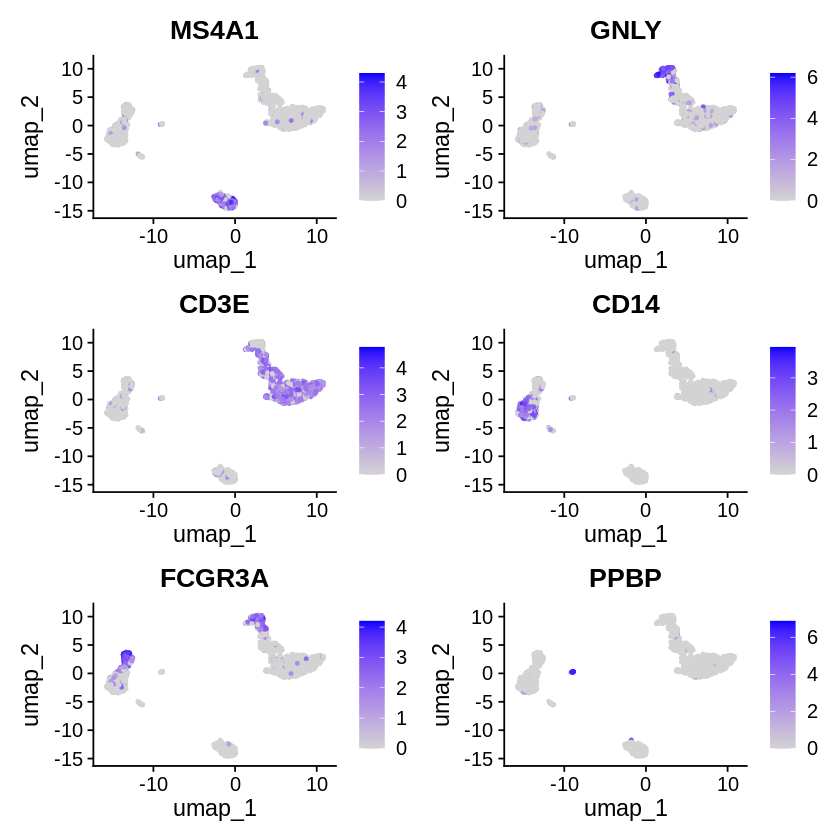

In [36]:
FeaturePlot(seurat_object, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCGR3A", "PPBP"))

In [39]:
num_clusters <- length(levels(seurat_object))
print(paste("Clusters: ", num_clusters))

[1] "Clusters:  12"


In [40]:
cluster_ids <- c(
  "Naive CD4 T",
  "CD14+ Mono",
  "Memory CD4 T",
  "B Cells",
  "CD8 T",
  "NK Cells",
  "FCGR3A+ Mono",
  "Dendritic DC",
  "T Cell Mix",
  "Platelets",
  "Cluster 10",
  "Cluster 11"
)

In [41]:
names(cluster_ids) <- levels(seurat_object)
seurat_object <- RenameIdents(seurat_object, cluster_ids)

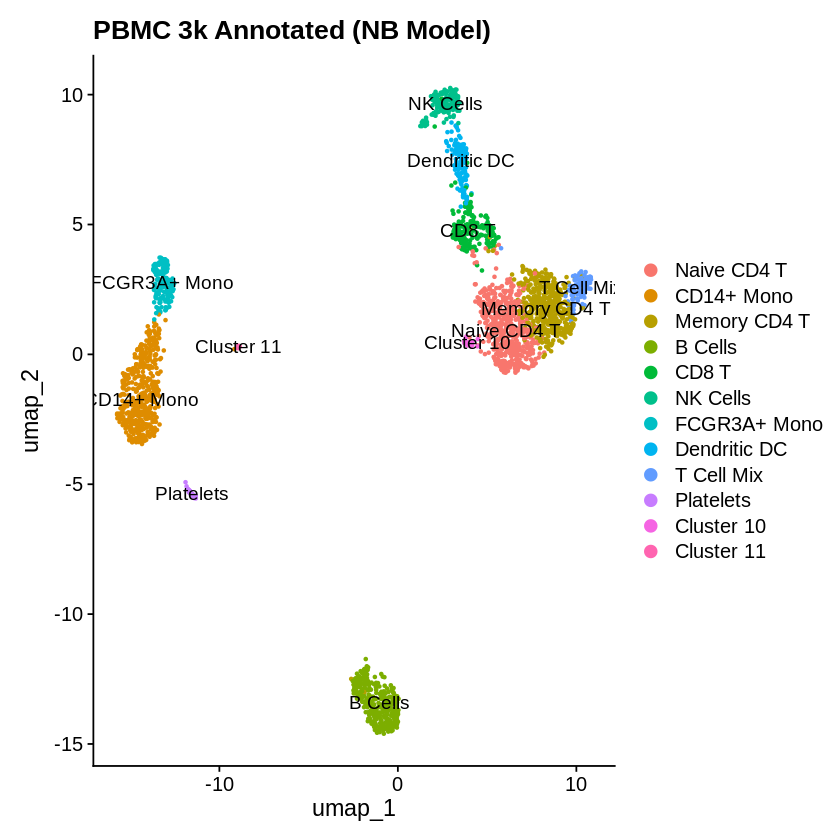

In [42]:
DimPlot(seurat_object, reduction = "umap", label = TRUE, pt.size = 0.5) +
  ggtitle("PBMC 3k Annotated (NB Model)")